# Sajad Hosseini Najafabadi
# 400301997

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# GPUs Available:  1


# 2.A Transfer learning

In [ ]:
'''CIFAR-10 images are 32*32, but imagenet pictures are 224*224. So we need to resize input images first. I decided to use
   Upsampling to do this.'''

input_layer = layers.Input(shape=(32,32,3))
resize_layer = layers.UpSampling2D(size=(7,7))(input_layer)

# Using pretrained ResNet50 as Feature Extractor.'''
feature_extractor = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(224, 224, 3))(resize_layer)
x = layers.GlobalAveragePooling2D()(feature_extractor)
x = layers.Flatten()(x)
output_layer = layers.Dense(10, activation="softmax", name="classification")(x)
ResNet50a = models.Model(inputs=input_layer, outputs = output_layer)

In [ ]:
ResNet50a.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 classification (Dense)      (None, 10)                20490 

In [ ]:
# Freezing pretrained ResNet50

ResNet50a.layers[2].trainable=False
ResNet50a.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 classification (Dense)      (None, 10)                20490 

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('./saved_model/ResNet50a.h5', monitor='val_loss', mode='min', save_best_only=True)

ResNet50a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')

In [2]:
# load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
# Performing normalization on images in training and test set.
x_train = x_train.astype('float32')
x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = x_test.astype('float32')
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)

In [ ]:
history = ResNet50a.fit(x_train, y_train,  validation_split=0.15, batch_size=32, callbacks=[es, rlrop, mch], epochs=10, verbose=1)

Epoch 1/10
1329/1329 [==============================] - 166s 122ms/step - loss: 0.3566 - accuracy: 0.8755 - val_loss: 0.4894 - val_accuracy: 0.8332 - lr: 0.0010
Epoch 2/10
1329/1329 [==============================] - 162s 122ms/step - loss: 0.3414 - accuracy: 0.8802 - val_loss: 0.5504 - val_accuracy: 0.8236 - lr: 0.0010
Epoch 3/10
1329/1329 [==============================] - 162s 122ms/step - loss: 0.3353 - accuracy: 0.8814 - val_loss: 0.4986 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 4/10
1329/1329 [==============================] - 163s 123ms/step - loss: 0.2669 - accuracy: 0.9088 - val_loss: 0.4505 - val_accuracy: 0.8489 - lr: 2.0000e-04
Epoch 5/10
1329/1329 [==============================] - 162s 122ms/step - loss: 0.2617 - accuracy: 0.9115 - val_loss: 0.4461 - val_accuracy: 0.8509 - lr: 2.0000e-04
Epoch 6/10
1329/1329 [==============================] - 161s 121ms/step - loss: 0.2600 - accuracy: 0.9132 - val_loss: 0.4569 - val_accuracy: 0.8463 - lr: 2.0000e-04
Epoch 7/10
1329/1329 [

In [ ]:
idx = np.argmin(history.history['val_loss'])
print("The best model based on minimum validation loss has the following properties:")
print(f"val_loss: {history.history['val_loss'][idx]:.3f} | val_accuracy: {100*history.history['val_accuracy'][idx]:.2f} %")

The best model based on minimum validation loss has the following properties:
val_loss: 0.442 | val_accuracy: 85.16 %


In [ ]:
# Evaluate loss and accuracy on test data
loss, accuracy = ResNet50a.evaluate(x_test, y_test, batch_size=64)

157/157 [==============================] - 27s 170ms/step - loss: 0.4909 - accuracy: 0.8379


In [ ]:
print(f'test_loss: {loss:.3f} | test_accuracy: {100*accuracy:.2f} %')

test_loss: 0.491 | test_accuracy: 83.79 %


# 2.B: Knowledge Distillation

In [6]:
# Implementing Knowledge Distillation
# Source: https://keras.io/examples/vision/knowledge_distillation/

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [7]:
# Defining teacher model.
teacher = ResNet50a

In [8]:
# Implementing ResNet-18
# Source: https://www.kaggle.com/code/duanjingxian/implementing-resnet-18-using-keras

from tensorflow.keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
class ResnetBlock(models.Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(models.Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [10]:
# Defining student model.

student = ResNet18(10)
student.build(input_shape = (None,227,227,3))

In [11]:
student.summary()

Model: "res_net18_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_20 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_8 (ResnetBlock  multiple                 74368     
 )                                                               
                                                                 
 resnet_block_9 (ResnetBlock  multiple                 74368     
 )                                                     

In [16]:
# make distiller model

distiller = Distiller(student=student, teacher=teacher)

es = EarlyStopping(monitor='val_student_loss', mode='min', patience=3)
rlrop = ReduceLROnPlateau(monitor='val_student_loss', patience=2, factor=0.2, min_lr=0.0001)

distiller.compile(
    optimizer='adam',
    metrics = 'accuracy',
    student_loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    # I got the best results with these hyperparameters:
    alpha=0.2,
    temperature=2,
)

In [18]:
history = distiller.fit(x_train, y_train,  validation_split=0.15, batch_size=32, callbacks=[es, rlrop], epochs=10, verbose=1)

Epoch 1/10
1329/1329 [==============================] - 157s 118ms/step - accuracy: 0.8138 - student_loss: 0.5435 - distillation_loss: 0.0122 - val_accuracy: 0.7128 - val_student_loss: 1.5362 - lr: 0.0010
Epoch 2/10
1329/1329 [==============================] - 155s 117ms/step - accuracy: 0.8459 - student_loss: 0.4511 - distillation_loss: 0.0109 - val_accuracy: 0.7224 - val_student_loss: 2.9415 - lr: 0.0010
Epoch 3/10
1329/1329 [==============================] - 155s 116ms/step - accuracy: 0.8719 - student_loss: 0.3691 - distillation_loss: 0.0099 - val_accuracy: 0.7452 - val_student_loss: 1.6805 - lr: 0.0010
Epoch 4/10
1329/1329 [==============================] - 156s 117ms/step - accuracy: 0.9544 - student_loss: 0.1467 - distillation_loss: 0.0070 - val_accuracy: 0.7776 - val_student_loss: 2.4607 - lr: 2.0000e-04


In [21]:
# Evaluate loss and accuracy on test data
accuracy, student_loss =distiller.evaluate(x_test, y_test, batch_size=64)

157/157 [==============================] - 1s 9ms/step - accuracy: 0.7624 - student_loss: 0.8768


In [22]:
print(f'test_loss: {student_loss:.3f} | test_accuracy: {100*accuracy:.2f} %')

test_loss: 0.896 | test_accuracy: 76.24 %


# 2.C: Training the full ResNet18 on CIFAR-10

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=0.0001)

student.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')

In [34]:
history = student.fit(x_train, y_train,  validation_split=0.15, batch_size=32, callbacks=[es, rlrop], epochs=10, verbose=1)

Epoch 1/10
1329/1329 [==============================] - 157s 22ms/step - loss: 0.2200 - accuracy: 0.9238 - val_loss: 0.9492 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 2/10
1329/1329 [==============================] - 29s 22ms/step - loss: 0.1746 - accuracy: 0.9409 - val_loss: 1.1418 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 3/10
1329/1329 [==============================] - 29s 22ms/step - loss: 0.2755 - accuracy: 0.9086 - val_loss: 1.0620 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 4/10
1329/1329 [==============================] - 29s 22ms/step - loss: 0.0408 - accuracy: 0.9872 - val_loss: 1.0453 - val_accuracy: 0.7736 - lr: 2.0000e-04


In [36]:
# Evaluate loss and accuracy on test data
loss, accuracy = student.evaluate(x_test, y_test, batch_size=64)

157/157 [==============================] - 1s 9ms/step - loss: 1.0662 - accuracy: 0.7622


In [37]:
print(f'test_loss: {loss:.3f} | test_accuracy: {100*accuracy:.2f} %')

test_loss: 1.066 | test_accuracy: 76.22 %


As we can see from student loss values, which is evaluated on test data in parts B and C, It is clear that the loss value with the help of the teacher is lesser than no teacher scenario.
The reason for that is the use of soft labels which helps the student learning process.
But its accuracy is only an epsilon better. The reason can be the lack of proper selection of alpha and T hyperparameters in the try-and-error process.
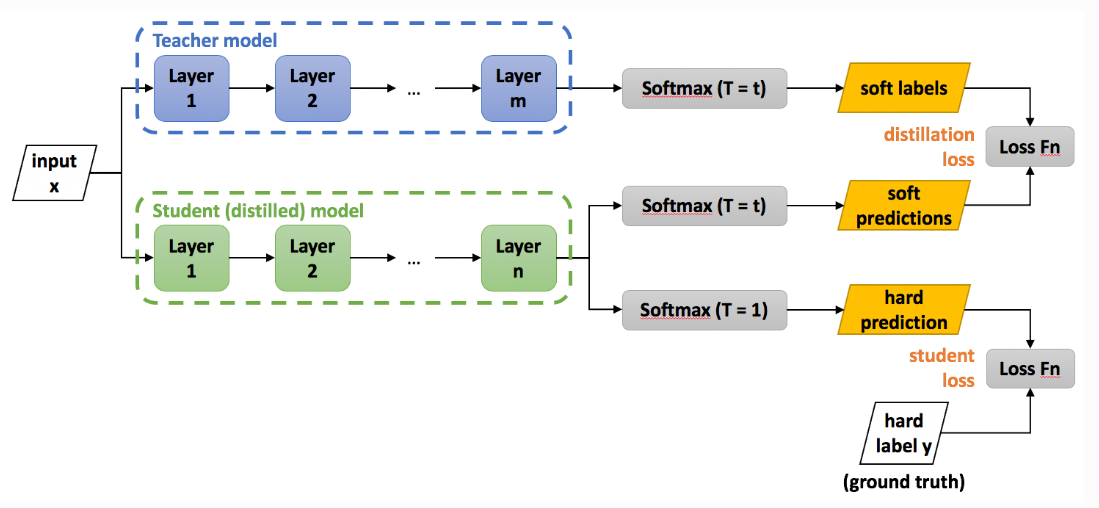

# 2.D: Fine-tuning the full ResNet50 on CIFAR-10

In [39]:
input_layer = layers.Input(shape=(32,32,3))
resize_layer = layers.UpSampling2D(size=(7,7))(input_layer)

# Using pretrained ResNet50 as Feature Extractor.'''
feature_extractor = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(224, 224, 3))(resize_layer)
x = layers.GlobalAveragePooling2D()(feature_extractor)
x = layers.Flatten()(x)
output_layer = layers.Dense(10, activation="softmax", name="classification")(x)
ResNet50d = models.Model(inputs=input_layer, outputs = output_layer)

94765736/94765736 [==============================] - 5s 0us/step


In [40]:
ResNet50d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 classification (Dense)      (None, 10)                20490 

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
rlrop = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=0.0001)
mch = ModelCheckpoint('./saved_model/ResNet50d.h5', monitor='val_loss', mode='min', save_best_only=True)

ResNet50d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')

In [42]:
history = ResNet50d.fit(x_train, y_train,  validation_split=0.15, batch_size=32, callbacks=[es, rlrop, mch], epochs=10, verbose=1)

Epoch 1/10
1329/1329 [==============================] - 493s 367ms/step - loss: 0.7961 - accuracy: 0.7273 - val_loss: 0.8661 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 2/10
1329/1329 [==============================] - 484s 364ms/step - loss: 0.4600 - accuracy: 0.8440 - val_loss: 0.8262 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 3/10
1329/1329 [==============================] - 484s 364ms/step - loss: 0.3389 - accuracy: 0.8826 - val_loss: 0.6735 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 4/10
1329/1329 [==============================] - 484s 364ms/step - loss: 0.2570 - accuracy: 0.9106 - val_loss: 0.4664 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 5/10
1329/1329 [==============================] - 484s 364ms/step - loss: 0.1857 - accuracy: 0.9358 - val_loss: 0.4393 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 6/10
1329/1329 [==============================] - 482s 363ms/step - loss: 0.1386 - accuracy: 0.9518 - val_loss: 0.4447 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 7/10
1329/1329 [============

In [43]:
idx = np.argmin(history.history['val_loss'])
print("The best model based on minimum validation loss has the following properties:")
print(f"val_loss: {history.history['val_loss'][idx]:.3f} | val_accuracy: {100*history.history['val_accuracy'][idx]:.2f} %")

The best model based on minimum validation loss has the following properties:
val_loss: 0.294 | val_accuracy: 91.97 %


In [45]:
# Evaluate loss and accuracy on test data
loss, accuracy = ResNet50d.evaluate(x_test, y_test, batch_size=64)

157/157 [==============================] - 32s 202ms/step - loss: 0.3682 - accuracy: 0.9090


In [46]:
print(f'test_loss: {loss:.3f} | test_accuracy: {100*accuracy:.2f} %')

test_loss: 0.368 | test_accuracy: 90.90 %


According to the results, it can be seen that the accuracy of the model in this section is higher than in part A. Because initial weights are selected in such a way that the first hidden layers are extracting good features such as edges from the images. So fine-tuning it with new images increases the accuracy. But it was not too much. The reason is that the number of CIFAR-10 images is much less compared to ImageNet images. So feature extraction of hidden layers will not improve so much. Also, it takes much more time for the learning process, so it is better to use the method in part A for the case we lack time. in other words, there is a trade-off between time and accuracy.